# WMTRFM Python Development Notebook
***

Preliminary Python development space for `wmfr` Fortran code located in:

`/global/cfs/cdirs/m4259/bmoorema/wmfr_code`

This latest version uses the state equation from McDougall, Jackett, Wright and Feistel 2003, as does the Fortran code. However, there are still significant residuals between the Fortran and Python calculations (see [plots](#Plots) below). An outstanding issue is how to handle the buoyancy flux due to salt. The POP variables appear to be in kg of salt instead of g, however a simple factor of $10^3$ scaling does not resolve the agreement. There are also factors of $10^{-3}$ throughout the state module in `wmtr` that are poorly documented.

Here I multiply surface salinity by $10^{-3}$ which gives the closest agreement. This step is present in `wmtr` but commented out, and also indicated in some published versions of the water mass analysis (e.g., [Zhang and Talley 1998, JPO](https://doi.org/10.1175/1520-0485(1998)028<1961:HABBAM>2.0.CO;2)).

In [1]:
import numpy as np
import xarray as xr
import fastjmd95 as eos_jm
from pop_tools import eos as eos_mjwf
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Processing code

Functions

In [3]:
def calc_state(sss, sst, z0, eos='mjwf'):
    """Equation of state calculations
    
    Options:
    
       eos='jm': Jackett and McDougal 1995 (MPAS-Ocean)
       Use package fastjmd95 by R. Abernathey and J. Busecke
       
         pip install fastjmd95
       
       eos='mjwf': McDougall, Jackett, Wright and Feistel 2003 (POP)
       Use library pop_tools.eos from NCAR CESM pop-tools package
       
         conda install -c conda-forge pop-tools
    """
    
    # Jackett and McDougall 1995
    if eos == 'jm':
        rho, drhods, drhodt = [getattr(eos_jm, func)(sss, sst, z0) for func in ('rho', 'drhods', 'drhodt')]
    
    # McDougall, Jackett, Wright and Feistel 2003
    elif eos == 'mjwf':
        rho, drhods, drhodt = eos_mjwf(sss, sst, pressure=z0, return_coefs=True)
    
    else:
        raise ValueError(f'Unknown equation of state: {eos}')
    
    # Calc sigma, alpha and beta
    sigma = rho - 1000
    alpha = -drhodt / rho
    beta = drhods / rho
    
    return sigma, alpha, beta


def calc_totals(tr):
    """Calculate total transformations and formations
    """

    # Calculate totals
    tr['total'] = tr['heat'] + tr['salt']
    tr['total_ice'] = tr['heat_ice'] + tr['salt_ice']
    tr['total_noice'] = tr['total'] - tr['total_ice']
    
    # Calculate watermass formation
    fm = {}
    for name in tr:
        fm[name] = -np.diff(tr[name], append=0)
    
    return {'tr': tr, 'fm': fm}


def plot_results(residuals=False):
    """Plot transformation results (residuals are f90-py)
    """
    
    # Make plot layout
    fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    xlim = [21.5, 28]
    titlesfx = ' residuals (f90-py)' if residuals else ''
    
    # Loop through columns
    for col, qty, titleprfx in zip(axs.T, ['tr', 'fm'], ['Transformation', 'Formation']):
        
        # Column formatting
        col[0].set_title(titleprfx + titlesfx)
        col[0].xaxis.set_ticklabels('')
        col[1].set_xlabel('$\\sigma_{\\theta}$')
        
        # Loop regions
        for ax, hs, region in zip(col, ['sh', 'nh'], [0, 5]):
            
            # Plot results
            for name, ls in zip(['heat', 'salt', 'total'], ['--', ':', '-']):
                if residuals:
                    ylim = [-5, 5]
                    y = np.subtract(*[wmtrfm[code][hs][qty][name][region, :] for code in ('f90', 'py')])
                    ax.plot(dclass[:-1], y, ls, color='k', label=name)
                else:
                    ylim = [-40, 40]
                    ax.plot(0, 0, ls, color='lightgray', label=name)
                    for code, c in zip(['f90', 'py'], ['k', 'r']):
                        label = code if name == 'total' else None
                        y = wmtrfm[code][hs][qty][name][region, :]
                        ax.plot(dclass[:-1], y, ls, color=c, label=label)
            
            # Formatting
            ax.plot(xlim, [0, 0], '--', color='gray', zorder=0)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            if qty == 'tr':
                ax.text(0.01, 0.9, regiondict[region], transform=ax.transAxes)
            else:
                ax.yaxis.set_ticklabels('')

    # Final formatting
    axs[1, 0].set_ylabel('Sv', y=1.1)
    axs[1, 1].legend(loc=2)

Define regions

In [4]:
# Define regions
regiondict = {
    0:  'Southern Ocean',
    1:  'Pacific Ocean',
    2:  'Indian Ocean',
    3:  'Persian Gulf',
    4:  'Red Sea',
    5:  'Atlantic Ocean',
    6:  'Mediterranean Sea',
    7:  'Labrador Sea',
    8:  'Greenland Sea',
    9:  'Arctic Ocean',
    10: 'Hudson Bay',
    11: 'Baltic Sea',
    12: 'Black Sea',
    13: 'Caspian Sea',
    14: 'Total',
}

Define constants and parameters

In [5]:
# Define constants and parameters
cpsw = 3.996e3  # Heat capacity of seawater [W/kg*degC]
nreg = 15       # Number of regions
dinc = 0.1      # Sigma bin size
ndinc = 101     # Number of sigma bins
sigma0 = 19     # Sigma start

# Create sigma classes
dclass = np.append(np.arange(ndinc) * dinc + sigma0, 1e32)

# Results paths
resultspath = '/pscratch/sd/b/bmoorema/results/'
wmtr_dir = 'wmfr_output/bc5_ne120_t12_v0.1_00002/TR/'
pop_dir = 'bc5_ne120_t12_v0.1/'

# Fluxes due to ice formation (not available from POP results)
qflux, qflux_s = 0, 0

# TRFM variable names
trnames = ['area', 'heat', 'salt', 'heat_ice', 'salt_ice']

# Results file record dates
years, months = list(range(1996, 2001)), list(range(1, 13))
nyears, nmonths = len(years), len(months)

Load `wmtr` Fortran outputs

In [6]:
# Load and processes data from Fortran binary outputs
wmtrfm = {'f90': {}, 'py': {}}
for hs in ['nh', 'sh']:

    # Load data from Fortran binary (double precision, big endian)
    # Use numpy.fromfile, for some reason scipy.io.FortranFile doesn't play nice here
    data = np.fromfile(resultspath + wmtr_dir + f'transfrm_{hs}_ann_2000.dat', dtype='>f8')
    
    # Convert to float64, reshape to [record, regions, variables] and parse variables to dict
    # Multiply by 1e-6 to convert to Sv (or km2 for area)
    data = list(data.astype('float64').reshape([101, 15, 5], order='F').T * 1e-6)
    wmtrfm['f90'][hs] = calc_totals({name: values for name, values in zip(trnames, data)})

Recalculate `wmtr` results from POP in Python

In [7]:
# Build transformation dict (sigma bins x regions)
tr = {hs: {name: np.zeros((nreg, ndinc)) for name in trnames} for hs in ('nh', 'sh')}

# Loop through years and months
for year in years:
    for month in tqdm(months, desc=f'Loading {year}...'):
        
        # Open results file and extract variables
        datestr = datetime(year, month, 1).strftime('%Y-%m')
        filename = f'bc5_ne120_t12_v0.1_00002.pop.h.{datestr}.nc'
        with xr.open_dataset(resultspath + pop_dir + filename) as ds:

            # Prepare masks
            landmask = ds['KMT'].values.flatten()
            landmask = landmask > 0

            # Load coordinates
            names = ['TLONG', 'TLAT', 'TAREA', 'REGION_MASK']
            lon, lat, area, regionmask = [ds[name].values.flatten()[landmask] for name in names]
            regionmask = abs(regionmask)      # [1, 14]
            area = area * 1e-4                # m2
            z0 = ds['z_t'].values[0] * 1e-2   # m

            # Load 2d variables
            names = ['SHF', 'SFWF', 'MELTH_F', 'MELT_F', 'SALT_F']
            shf, sfwf, melth_f, melt_f, salt_f = [ds[name][0, ...].values.flatten()[landmask] for name in names]

            # Load 3d variables at surface
            names = ['TEMP', 'SALT']
            sst, sss = [ds[name][0, 0, ...].values.flatten()[landmask] for name in names]
            sss[sss < 0] = 0
        
        # Density calculations
        sigma, alpha, beta = calc_state(sss, sst, z0, eos='mjwf')
        
        # In some formulations of surface buoyancy flux due to salt
        # (e.g., Zhang and Talley 1998, JPO)
        # Also present in wmtr f90 code but commented out,
        # however the max(SSS) printed to stdout appears to be scaled by 1e-3
        sss = sss * 1e-3

        # Buoyancy fluxes
        coefheat = -alpha / cpsw
        coefsalt = beta * sss / (1 - sss)
        bfluxvars = {
            'heat': coefheat * (shf + qflux),
            'salt': -coefsalt * (sfwf + qflux_s),
            'heat_ice': coefheat * (melth_f + qflux),
            'salt_ice': coefsalt * (salt_f + melt_f + qflux_s),
            'sigma': sigma,
            'area': area,
        }

        # Loop through hemispheres
        for hs, func in zip(['nh', 'sh'], ['greater', 'less_equal']):

            # Hemisphere mask
            hmask = getattr(np, func)(lat, 0)

            # Loop through regions
            for reg in range(1, nreg):

                # Mask region
                bfv = {}
                rmask = (regionmask == reg) & hmask
                for name in bfluxvars:
                    bfv[name] = bfluxvars[name][rmask]

                # Loop through density bins
                for i in range(ndinc):
                    dmask = (bfv['sigma'] >= dclass[i]) & (bfv['sigma'] <= dclass[i+1])
                    for name in trnames:
                        values = bfv[name][dmask] if name != 'area' else 1
                        tr[hs][name][reg-1, i] = tr[hs][name][reg-1, i] + np.nansum(values * bfv['area'][dmask])

# Final processing
for hs in ['nh', 'sh']:
    
    # Integration increment and conversion to Sv (or km2 for area)
    for name in trnames:
        tr[hs][name] = tr[hs][name] / (nyears * nmonths) * 1e-6
        if name != 'area':
            tr[hs][name] = tr[hs][name] / dinc
    
    # Calculate totals
    wmtrfm['py'][hs] = calc_totals(tr[hs])

Loading 2000...: 100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


***

### Plots

Plot transformation/formation curves for SHSO and NHNA

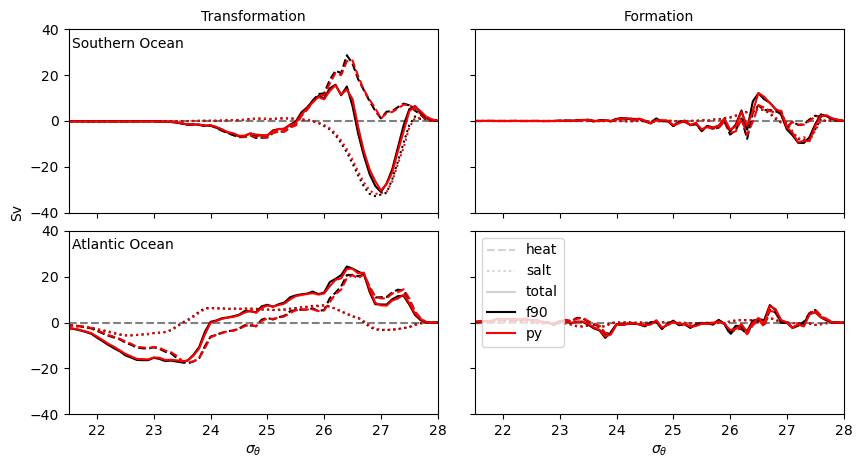

In [8]:
# Plot results
plot_results(residuals=False)

Plot residuals (`f90-py`)

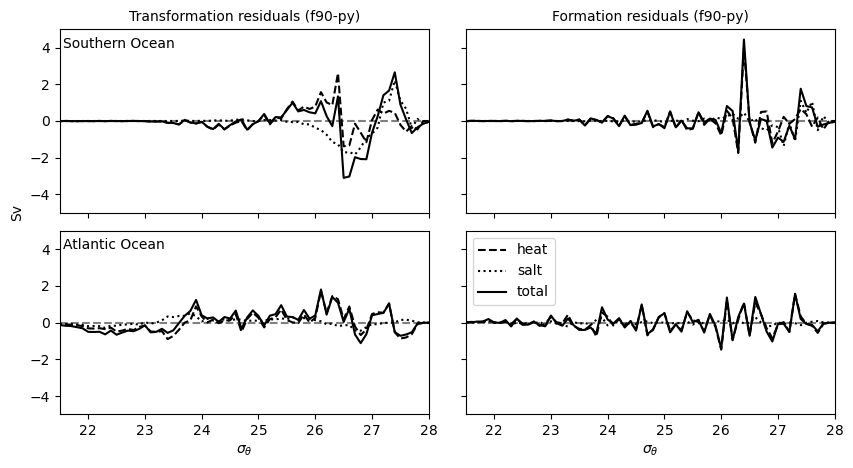

In [9]:
# Plot results
plot_results(residuals=True)